# **EDA**

## PRESENTACIÓN DEL DATAFRAME

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu

In [2]:
df_drugs = pd.read_csv("../data/data_clean/drugs.csv", index_col=0)
df_drugs_no_na = pd.read_csv("../data/data_clean/drugs_no_na.csv", index_col=0)

In [7]:
df_drugs

,country,survey_year,prevalence_(%),substance,recall_period,age,sample_size,males_(%),females_(%),gender_gap
0,Austria,2020,22.7,Cannabis,Lifetime,Adults (15-64),4650.0,24.8,20.6,4.2
1,Austria,2020,27.2,Cannabis,Lifetime,Young adults (15-34),1712.0,26.8,27.6,-0.8
2,Austria,2020,6.3,Cannabis,Last year,Adults (15-64),4650.0,6.8,5.8,1.0
3,Austria,2020,11.1,Cannabis,Last year,Young adults (15-34),1712.0,10.7,11.4,-0.7
4,Austria,2020,3.6,Cannabis,Last month,Adults (15-64),4650.0,4.0,3.1,0.9
...,...,...,...,...,...,...,...,...,...,...
1038,Türkiye,2017,47.0,Tobacco,Lifetime,Young adults (15-34),NaN,61.9,33.2,28.7
1039,Türkiye,2017,33.4,Tobacco,Last year,Adults (15-64),NaN,45.0,22.5,22.5
1040,Türkiye,2017,33.2,Tobacco,Last year,Young adults (15-34),NaN,45.4,20.6,24.8
1041,Türkiye,2017,31.5,Tobacco,Last month,Adults (15-64),NaN,42.8,21.0,21.8


El conjunto de datos contiene 1043 observaciones de consumo de estupefacientes en Europa y Turquía, recopiladas en diversos años y para distintos grupos de edad. Cada fila representa una medición específica del consumo de una sustancia en un país, un período de referencia y un grupo etario determinado.

**Columnas principales:**

* country: País donde se realizó la encuesta (países europeos y Turquía)

* survey_year: Año en el cual se realizó la encuesta (rango 2008-2022).

* prevalence_(%): Porcentaje de la población que ha consumido el estupefaciente 

* substance: Tipo de sustancia evaluada, como Cannabis, Tobacco, Cocaine, entre otros.

* recall_period: Periodo de referencia del consumo: Lifetime (consumo alguna vez), Last year (último año), Last month (último mes).

* age: Grupo de edad de la población encuestada - Adults (15-64) o Young adults (15-34).

* sample_size: Tamaño de la muestra utilizada en la encuesta

* males_(%) y females_(%): Porcentaje de hombres y mujeres que reportan haber consumido la sustancia.

* gender_gap: Diferencia entre hombres y mujeres (males_(%) - females_(%))


# **ANÁLISIS: CARDINALIDAD**

## 1. CARDINALIDAD: ANÁLISIS UNIVARIANTE

In [17]:
# Función que calcula la cardinalidad y el tipo de variable
def cardinalidad(df_in, umbral_categoria = 10, umbral_continua = 30):

    resultado = []
    for col in df_in.columns:
        card = df_in[col].nunique()
        porc_card = df_in[col].nunique()/len(df_in) * 100
        tipo = df_in[col].dtypes
        if card == 2:
            clasif = "Binaria"
        elif card < umbral_categoria:
            clasif = "Categórica"
        elif card >= umbral_categoria:
            if porc_card >= umbral_continua:
                clasif = "Numérica Continua"
            else:
                clasif = "Numérica Discreta"

        # Añadimos los resultados a la lista
        resultado.append({
            "columna": col,
            "tipo": tipo,
            "cardinalidad": card,
            "porcentaje_card": porc_card,
            "clasificacion": clasif
        })
    
    # Convertimos la lista de dicts en dataframe
    df_resul = pd.DataFrame(resultado)
        
    return df_resul

# 3. Función que representa las frecuencias absolutas o relativas en gráficos
def pinta_distribucion_categoricas(df, columnas_categoricas, relativa=False, mostrar_valores=False):
    num_columnas = len(columnas_categoricas)
    num_filas = (num_columnas // 2) + (num_columnas % 2)

    fig, axes = plt.subplots(num_filas, 2, figsize=(15, 5 * num_filas))
    axes = axes.flatten() 

    for i, col in enumerate(columnas_categoricas):
        ax = axes[i]
        if relativa:
            total = df[col].value_counts().sum()
            serie = df[col].value_counts().apply(lambda x: x / total)
            sns.barplot(x=serie.index, y=serie, ax=ax, palette='viridis', hue = serie.index, legend = False)
            ax.set_ylabel('Frecuencia Relativa')
        else:
            serie = df[col].value_counts()
            sns.barplot(x=serie.index, y=serie, ax=ax, palette='viridis', hue = serie.index, legend = False)
            ax.set_ylabel('Frecuencia')

        ax.set_title(f'Distribución de {col}')
        ax.set_xlabel('')
        ax.tick_params(axis='x', rotation=45)

        if mostrar_valores:
            for p in ax.patches:
                height = p.get_height()
                ax.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height), 
                            ha='center', va='center', xytext=(0, 9), textcoords='offset points')

    for j in range(i + 1, num_filas * 2):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def columnas_numericas(df):
    num_col = df.describe().columns.to_list()
    return num_col

# Función para representar boxplots de columnas numéricas
def plot_multiple_boxplots(df, columns, dim_matriz_visual = 2):
    num_cols = len(columns)
    num_rows = num_cols // dim_matriz_visual + num_cols % dim_matriz_visual
    fig, axes = plt.subplots(num_rows, dim_matriz_visual, figsize=(12, 6 * num_rows))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        if df[column].dtype in ['int64', 'float64']:
            sns.boxplot(data=df, x=column, ax=axes[i])
            axes[i].set_title(column)

    # Ocultar ejes vacíos
    for j in range(i+1, num_rows * 2):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def plot_histo_dens(df, columns, bins=None):
    num_cols = len(columns)
    num_rows = num_cols // 2 + num_cols % 2
    fig, axes = plt.subplots(num_rows, 2, figsize=(12, 6 * num_rows))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        if df[column].dtype in ['int64', 'float64']:
            if bins:
                sns.histplot(df[column], kde=True, ax=axes[i], bins=bins)
            else:
                sns.histplot(df[column], kde=True, ax=axes[i])
            axes[i].set_title(f'Histograma y KDE de {column}')

    # Ocultar ejes vacíos
    for j in range(i + 1, num_rows * 2):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Función que representa el histograma y el boxplot de varias variables
def plot_combined_graphs(df, columns, whisker_width=1.5):
    num_cols = len(columns)
    if num_cols:
        
        fig, axes = plt.subplots(num_cols, 2, figsize=(12, 5 * num_cols))
        print(axes.shape)

        for i, column in enumerate(columns):
            if df[column].dtype in ['int64', 'float64']:
                # Histograma y KDE
                sns.histplot(df[column], kde=True, ax=axes[i,0] if num_cols > 1 else axes[0])
                if num_cols > 1:
                    axes[i,0].set_title(f'Histograma y KDE de {column}')
                else:
                    axes[0].set_title(f'Histograma y KDE de {column}')

                # Boxplot
                sns.boxplot(x=df[column], ax=axes[i,1] if num_cols > 1 else axes[1], whis=whisker_width)
                if num_cols > 1:
                    axes[i,1].set_title(f'Boxplot de {column}')
                else:
                    axes[1].set_title(f'Boxplot de {column}')

        plt.tight_layout()
        plt.show()

## 2. CARDINALIDAD: ANÁISIS BIVARIANTE

In [16]:
# Función análisis bivariante categóricas
def plot_categorical_relationship_fin(df, cat_col1, cat_col2, relative_freq=False, show_values=False, size_group = 5):

    # Prepara los datos
    count_data = df.groupby([cat_col1, cat_col2]).size().reset_index(name='count')
    total_counts = df[cat_col1].value_counts()
    
    # Convierte a frecuencias relativas si se solicita
    if relative_freq:
        count_data['count'] = count_data.apply(lambda x: x['count'] / total_counts[x[cat_col1]], axis=1)

    # Si hay más de size_group categorías en cat_col1, las divide en grupos de size_group
    unique_categories = df[cat_col1].unique()
    if len(unique_categories) > size_group:
        num_plots = int(np.ceil(len(unique_categories) / size_group))

        for i in range(num_plots):
            # Selecciona un subconjunto de categorías para cada gráfico
            categories_subset = unique_categories[i * size_group:(i + 1) * size_group]
            data_subset = count_data[count_data[cat_col1].isin(categories_subset)]

            # Crea el gráfico
            plt.figure(figsize=(5, 3))
            ax = sns.barplot(x=cat_col1, y='count', hue=cat_col2, data=data_subset, order=categories_subset)

            # Añade títulos y etiquetas
            plt.title(f'Relación entre {cat_col1} y {cat_col2} - Grupo {i + 1}')
            plt.xlabel(cat_col1)
            plt.ylabel('Frecuencia' if relative_freq else 'Conteo')
            plt.xticks(rotation=45)

            # Mostrar valores en el gráfico
            if show_values:
                for p in ax.patches:
                    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                                ha='center', va='center', fontsize=10, color='black', xytext=(0, size_group),
                                textcoords='offset points')

            # Muestra el gráfico
            plt.show()
    else:
        # Crea el gráfico para menos de size_group categorías
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(x=cat_col1, y='count', hue=cat_col2, data=count_data)

        # Añade títulos y etiquetas
        plt.title(f'Relación entre {cat_col1} y {cat_col2}')
        plt.xlabel(cat_col1)
        plt.ylabel('Frecuencia' if relative_freq else 'Conteo')
        plt.xticks(rotation=45)

        # Mostrar valores en el gráfico
        if show_values:
            for p in ax.patches:
                ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center', fontsize=10, color='black', xytext=(0, size_group),
                            textcoords='offset points')

        # Muestra el gráfico
        plt.show()

def grafico_dispersion_con_correlacion(df, columna_x, columna_y, tamano_puntos=50, mostrar_correlacion=False):
    """
    Crea un diagrama de dispersión entre dos columnas y opcionalmente muestra la correlación.

    Args:
    df (pandas.DataFrame): DataFrame que contiene los datos.
    columna_x (str): Nombre de la columna para el eje X.
    columna_y (str): Nombre de la columna para el eje Y.
    tamano_puntos (int, opcional): Tamaño de los puntos en el gráfico. Por defecto es 50.
    mostrar_correlacion (bool, opcional): Si es True, muestra la correlación en el gráfico. Por defecto es False.
    """

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=columna_x, y=columna_y, s=tamano_puntos)

    if mostrar_correlacion:
        correlacion = df[[columna_x, columna_y]].corr().iloc[0, 1]
        plt.title(f'Diagrama de Dispersión con Correlación: {correlacion:.2f}')
    else:
        plt.title('Diagrama de Dispersión')

    plt.xlabel(columna_x)
    plt.ylabel(columna_y)
    plt.grid(True)
    plt.show()

# **ANÁLISIS BASE**

A continuación, se muestran una serie de análisis base para todas las hipótesis del presente estudio.

In [8]:
df_drugs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1043 entries, 0 to 1042
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         1043 non-null   object 
 1   survey_year     1043 non-null   int64  
 2   prevalence_(%)  1043 non-null   float64
 3   substance       1043 non-null   object 
 4   recall_period   1043 non-null   object 
 5   age             1043 non-null   object 
 6   sample_size     950 non-null    float64
 7   males_(%)       1017 non-null   float64
 8   females_(%)     1001 non-null   float64
 9   gender_gap      1001 non-null   float64
dtypes: float64(5), int64(1), object(4)
memory usage: 89.6+ KB


El presente análisis muestra que nuestro dataset contiene 1043 filas, hehcho que mostraría un tamaño moderado para análisis estadísticos.

Asimismo, hay 10 columnas, de las cuales 4 son **categóricas** (country, substance, recall_period, age) y 6 **numéricas** (survey_year, prevalence_(%), sample_size, males_(%), females_(%), gender_gap)

Además, se observan valores faltantes (NaN) en:

* sample_size (950 de 1043) → faltaría información en algunas encuestas sobre el número de personas encuestadas.

* males_(%) (1017 de 1043) y females_(%) (1001 de 1043) → algunas encuestas no informan el porcentaje por sexo.

* gender_gap (1001 de 1043) → ya que se calcula como diferencia de los anteriores, los valores faltantes se transmiten.


In [9]:
df_drugs.describe()

,survey_year,prevalence_(%),sample_size,males_(%),females_(%),gender_gap
count,1043.000000,1043.000000,950.000000,1017.000000,1001.000000,1001.000000
mean,2018.776606,17.558581,4260.586316,19.904621,15.596803,4.624276
std,2.174479,26.759251,4568.853108,28.697494,25.437743,6.281016
min,2008.000000,0.000000,442.000000,0.000000,0.000000,-4.000000
25%,2018.000000,0.600000,1572.000000,0.800000,0.300000,0.400000
50%,2019.000000,2.800000,2957.000000,3.900000,1.800000,1.900000
75%,2020.000000,26.150000,4994.000000,32.000000,21.300000,6.600000
max,2022.000000,98.900000,26344.000000,99.600000,98.200000,38.400000


El estudio de .describe() proporciona información descriptiva de diversas columnas:
**survey_year**

* Media: 2018.78, desviación estándar: 2.17.

Los datos son recientes, principalmente del periodo 2018–2022, con algunos registros desde 2008.

Esto indica que el análisis se centra en consumos actuales o recientes, lo que es coherente con un EDA de tendencias modernas.

**prevalence_(%)**

* Media: 17.56%, desviación estándar: 26.76%, mínimo 0%, máximo 98.9%.

Hay una variabilidad alta en la prevalencia de consumo. La mayoría de los valores son bajos, pero hay encuestas con prevalencia muy alta, posiblemente para sustancias como alcohol o cannabis en grupos específicos.

**sample_size**

* Media: 4260, rango: 442–26,344.

La amplitud muestra que algunas encuestas son muy grandes y otras más pequeñas.

**males_(%) y females_(%)**

* Hombres: media 19.90%, std 28.69%

* Mujeres: media 15.60%, std 25.43%

En promedio, los hombres consumen más que las mujeres aunque hay una desviación estándard elevada. Esto podría mostrar dispersión e indicar que en algunos países tendrían consumos similares. 

**gender_gap**

* Media: 4.62%, mínimo -4%, máximo 38.4%

En promedio, hay mayor consumo en hombres, pero hay casos donde las mujeres superan a los hombres (valores negativos)

In [103]:
df_drugs.columns.tolist()

['country',
 'survey_year',
 'prevalence_(%)',
 'substance',
 'recall_period',
 'age',
 'sample_size',
 'males_(%)',
 'females_(%)',
 'gender_gap']

La lista de nuestras columnas confirma que tenemos todas las variables necesarias para analizar las hipótesis. Asimismo, es útil para planificar análisis univariantes (por ejemplo, solo prevalence_(%)), bivariantes (prevalence_(%) vs age o gender_gap) y multivariantes (prevalence_(%) vs gender_gap y country).

# **HIPÓTESIS 1**

>*H1. Los hombres consumen más estupefacientes que las mujeres en todos los grupos de edad*

## 1.1 ANÁLISIS UNIVARIANTE - ACABADOOOOOOOOO!!!

Antes de nada, volvemos a mostrar el dataframe:

In [29]:
df_drugs

,country,survey_year,prevalence_(%),substance,recall_period,age,sample_size,males_(%),females_(%),gender_gap
0,Austria,2020,22.7,Cannabis,Lifetime,Adults (15-64),4650.0,24.8,20.6,4.2
1,Austria,2020,27.2,Cannabis,Lifetime,Young adults (15-34),1712.0,26.8,27.6,-0.8
2,Austria,2020,6.3,Cannabis,Last year,Adults (15-64),4650.0,6.8,5.8,1.0
3,Austria,2020,11.1,Cannabis,Last year,Young adults (15-34),1712.0,10.7,11.4,-0.7
4,Austria,2020,3.6,Cannabis,Last month,Adults (15-64),4650.0,4.0,3.1,0.9
...,...,...,...,...,...,...,...,...,...,...
1038,Türkiye,2017,47.0,Tobacco,Lifetime,Young adults (15-34),NaN,61.9,33.2,28.7
1039,Türkiye,2017,33.4,Tobacco,Last year,Adults (15-64),NaN,45.0,22.5,22.5
1040,Türkiye,2017,33.2,Tobacco,Last year,Young adults (15-34),NaN,45.4,20.6,24.8
1041,Türkiye,2017,31.5,Tobacco,Last month,Adults (15-64),NaN,42.8,21.0,21.8


Para explorar la primera hipótesis, que plantea que los hombres consumen más drogas que las mujeres, se muestran datos descriptivos de las principales variables de la hipótesis: age, males_(%), females_(%), substance y prevalence_(%).

In [10]:
df_drugs["age"].describe()

count               1043
unique                 2
top       Adults (15-64)
freq                 528
Name: age, dtype: object

In [11]:
df_drugs["males_(%)"].describe()

count    1017.000000
mean       19.904621
std        28.697494
min         0.000000
25%         0.800000
50%         3.900000
75%        32.000000
max        99.600000
Name: males_(%), dtype: float64

In [12]:
df_drugs["females_(%)"].describe()

count    1001.000000
mean       15.596803
std        25.437743
min         0.000000
25%         0.300000
50%         1.800000
75%        21.300000
max        98.200000
Name: females_(%), dtype: float64

In [13]:
df_drugs["prevalence_(%)"].describe()

count    1043.000000
mean       17.558581
std        26.759251
min         0.000000
25%         0.600000
50%         2.800000
75%        26.150000
max        98.900000
Name: prevalence_(%), dtype: float64

In [14]:
df_drugs["substance"].describe()

count         1043
unique           7
top       Cannabis
freq           171
Name: substance, dtype: object

La variable **age** dejaría ver que la muestra se divide en dos grupos: Adults (15-64) y Young adults (15-34). La categoría más frecuente es la de adultos (528 observaciones), hecho que indicaría que la mayor parte de los datos corresponde a población adulta a pesar de que también se dispone de una representación significativa de jóvenes. 

En cuanto a los porcentajes de consumo por **sexo**, los hombres presentan un promedio de consumo de 19.90% y una mediana de 3.90%, frente un promedio de 15.60% y mediana de 1.80% de las mujeres. Asimismo, se presenta una desviación estándard elevada (28.7% vs. 25.4% respectivamente) que muestra una gran variabilidad. La mediana baja sugeriría que, en la mayoría de los casos, el consumo es relativamente reducido, pero algunos casos puntuales elevan considerablemente la media, indicando que existen grupos con prevalencias muy altas.

Finalmente, la variable **prevalence_(%)** muestra un comportamiento similar: promedio de 17.56% y rango que va de 0% a 98.9%. Esto confirmaría la heterogeneidad del consumo. 

Respecto a las **sustancias**, la mayoría de los registros corresponden a Cannabis (171 observaciones), aunque el dataset incluye un total de 7 tipos de drogas, como alcohol o cocaina, lo que permite comparar patrones de consumo entre distintas sustancias.

En conjunto, este análisis univariante sugiere que, en promedio, los hombres presentan mayores niveles de consumo que las mujeres, aunque existen casos donde la diferencia es mínima o incluso se invierte, y que la distribución de consumo varía considerablemente según grupo etario y sustancia.

### 1.1.1 Análisis univariante de variables **categóricas**

Para realizar el análisis univariante, se ha examinado la distribución de las **variables categóricas** relevantes para la primera hipótesis: substance y age.

Se ha hecho también un **conteo de los valores absolutos**:

In [42]:
categorical_var = [  
    "substance",
    "age",
]

In [57]:
for catego in categorical_var:
	print(f"Para {catego}")
	print(df_drugs[catego].value_counts())
	print("\n"*2)

Para substance
substance
Cannabis        171
Cocaine         159
Ecstasy         159
Amphetamines    149
LSD             148
Alcohol         132
Tobacco         125
Name: count, dtype: int64



Para age
age
Adults (15-64)          528
Young adults (15-34)    515
Name: count, dtype: int64





**Sustancia (substance)**
El dataset incluye 7 tipos de sustancias: Cannabis, Cocaína, Éxtasis, Anfetaminas, LSD, Alcohol y Tabaco. La distribución absoluta de sus registros muestra que Cannabis es la sustancia más frecuente (171 observaciones), seguida de Cocaína y Éxtasis (159 observaciones cada una). Las otras sustancias se reparten de manera relativamente uniforme, con un mínimo de 125 registros para Tabaco.

**Grupos de edad (age)**
El conteo absoluto indica que la muestra está muy equilibrada entre los Adultos (15-64 años) con 528 observaciones y los Jóvenes adultos (15-34 años) con 515 observaciones. Esto permite analizar cómo varía el consumo entre los hombres y las mujeres en función de la edad, por ejemplo, sin que uno de los grupos predomine sobre el otro.


Asimismo, se han generado un gráfico de barras para estas variables categóricas:

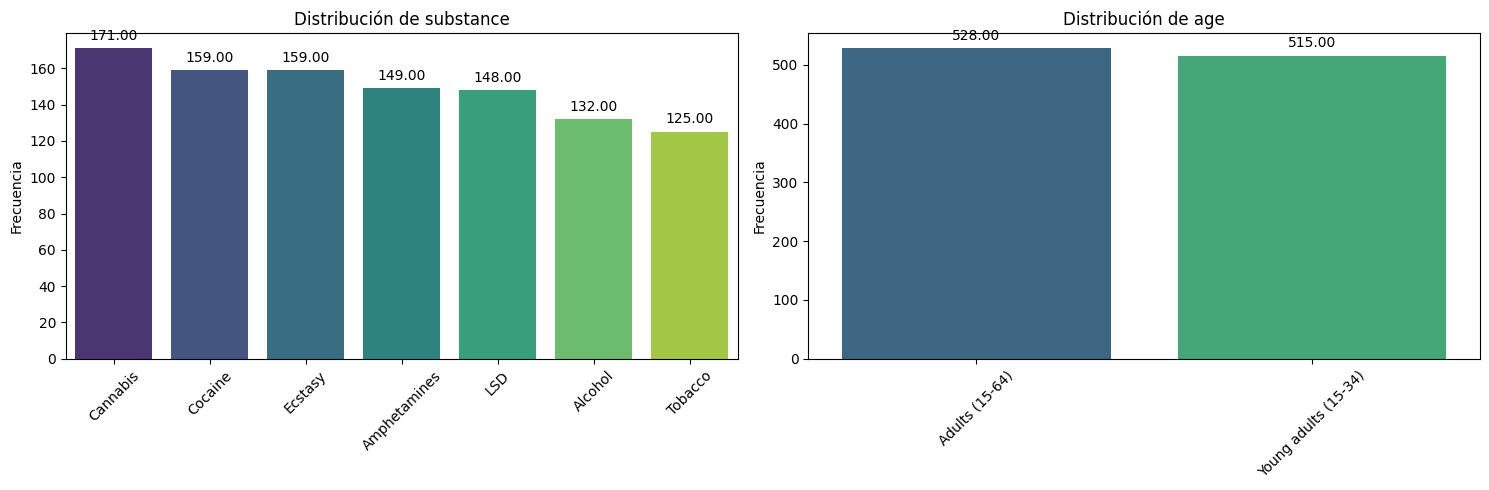

In [130]:
pinta_distribucion_categoricas(df_drugs, ["substance", "age"], relativa=False, mostrar_valores=True)

Este gráfico muestra la distribución de las sustancias, así como la prácticamente igualdad entre los grupos de edad. Con esta, se puede identificar dónde están concentrados la mayor parte de datos.
Ambas gráficas confirman lo que muestran los conteos absolutos anteriormanete mencionados:
* Substance: predomina el consumo de cannabis, seguida de cocaina, extasis, anfetaminas, LSD, alcohol y, finalmente, tabaco
* Age: se observa una representación equilibrada entre ambos grupos de edad

Para complementar el análisis en términos absolutos, se ha calculado la distribución **relativa** las variables substance y age, expresando los datos en porcentajes sobre el total de observaciones (1043).

In [105]:
for catego in categorical_var:
	print(f"Para {catego}")
	print(df_drugs[catego].value_counts()/len(df_drugs)*100)
	print("\n"*2)

Para substance
substance
Cannabis        16.395014
Cocaine         15.244487
Ecstasy         15.244487
Amphetamines    14.285714
LSD             14.189837
Alcohol         12.655801
Tobacco         11.984660
Name: count, dtype: float64



Para age
age
Adults (15-64)          50.623202
Young adults (15-34)    49.376798
Name: count, dtype: float64





**Substance**: Igual que en el análisis anterior, el cánnabis es la sustancia que más se observa (16.4%), seguida de la cocaina y extasis (15.24% cada una), las anfetaminas y el LSD (14.3% y 14.2% respectivamente), el alcohol (12.66%) y, finalmente, el tabado (12%)

**Age**: Se vuelve a apreciar que las dos franjas de edad (adulto y adultos jóvenes) están equilibrados, con aproximadamente los dos un 50% de representación

Para volver a observarlo de forma visual, se presenta, a continuación, una gráfica con los datos relativos aquí presentados:

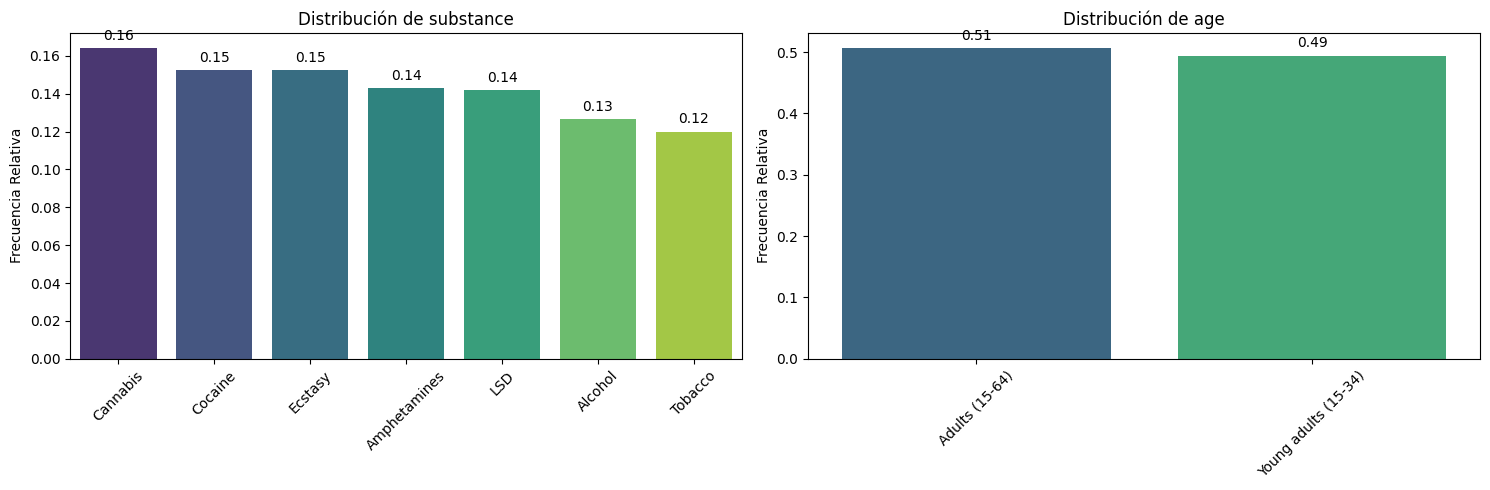

In [106]:
pinta_distribucion_categoricas(df_drugs, ["substance", "age"], relativa=True, mostrar_valores=True)

Tanto el análisis absoluto como el relativo indican que nuestro dataset tiene correcta diversidad de sustancias y equilibrio de edad, hecho que proporciona una base sólida para analizar la Hipótesis 1 respecto las diferencias de consumo entre hombres y mujeres.

### 1.1.2 Análisis univariante de variables **Numéricas**

Se ha llevado a cabo un análisis de las variables numéricas relevantes para la primera hipótesis, la cual tiene como objetivo estudiar si los hombres consumen más estupefacientes que las mujeres en todos los rangos de edad. Para ello, las **variables numéricas** que han sido examinadas son: prevalence_(%), males_(%) y females_(%).

In [30]:
num_cols = columnas_numericas(df_drugs)
numeric_cols = [
    "prevalence_(%)",
    "males_(%)",
    "females_(%)",
]   

Para el análisis univariante de las variables numéricas, tal y como se ha mencionado anteriormente, se seleccionaron únicamente prevalence_(%), males_(%) y females_(%) puesto que son las columnas vinculadas de forma directa con la Hipótesis 1. A pesar de que nuestro dataset dispone de otras columnas que también son numéricas, nuestra selección nos permite centrarnos en las métricas que son relevantes para nuestro estudio.

Asimismo y, de manera complementaria, se han identificado las columnas numéricas de nuestro dataset con el objetivo de disponer de una visión general del comportamiento de las variables.

Por su parte, se han generado histogramas con curvas de densidad, así como boxplots para las variables **prevalence_(%), males_(%) y females_(%)** para analizar visualmente patrones de consumo y facilitar la interpretación de la Hipótesis 1.

*Histograma*

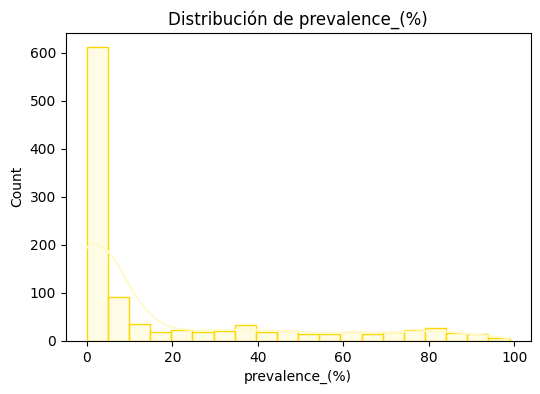

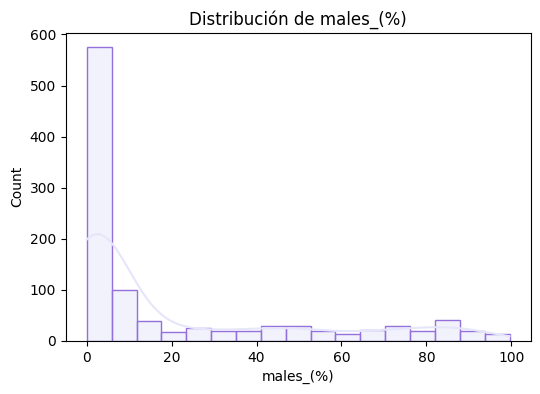

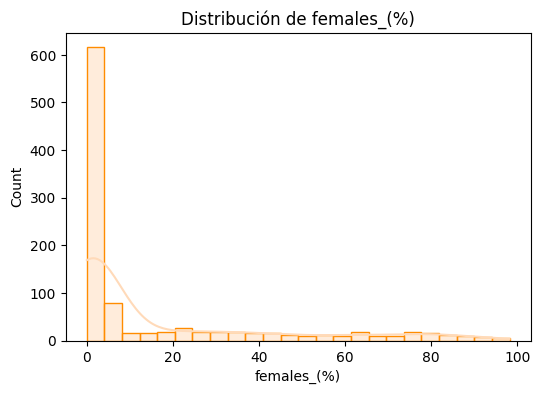

In [133]:
numeric_cols = ["prevalence_(%)", "males_(%)", "females_(%)"]
colors = ["#FFFACD", "#E6E6FA", "#FFDAB9"]
border_colors = ["#FFD700", "#9370DB", "#FF8C00"]

for i, col in enumerate(numeric_cols):
    plt.figure(figsize=(6,4))
    sns.histplot(
        df_drugs[col].dropna(),
        kde=True,
        color=colors[i],
        edgecolor=border_colors[i]
    )
    plt.title(f"Distribución de {col}")
    plt.show()

*Bloxplot*

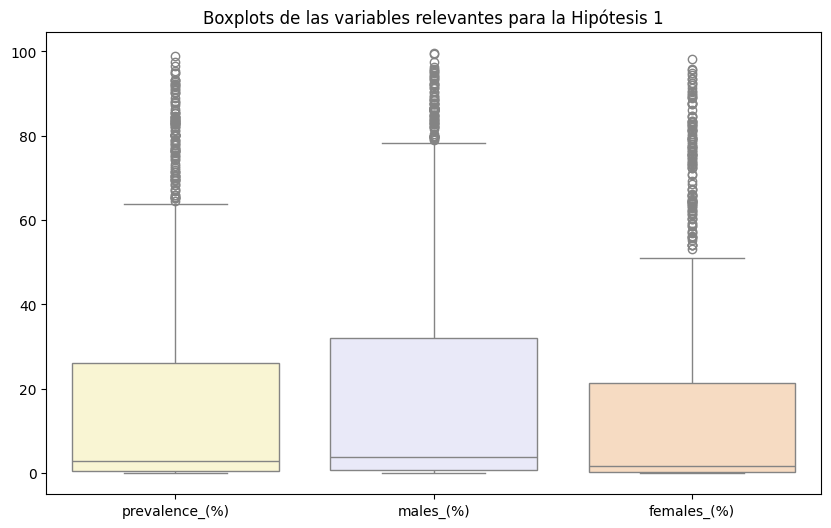

In [127]:
numeric_cols2 = ["prevalence_(%)", "males_(%)", "females_(%)"]
colors = ["#FFFACD", "#E6E6FA", "#FFDAB9"]

plt.figure(figsize=(10,6))
sns.boxplot(data=df_drugs[numeric_cols2], palette = colors)
plt.title("Boxplots de las variables relevantes para la Hipótesis 1")
plt.show()

**Prevalencia (prevalence_(%)**:

* El *histograma* expone que la mayoría de los registros se concentra en valores bajos (cercanos a 0–5%) a pesar de que hay casos extremos cercanos a 100%. Por su parte, la curva de densidad indicaría una distribución asimétrica con una larga cola hacia valores altos.

* Asimismo, los *boxplots* confirman la presencia de outliers (prevalencias muy elevadas en ciertas sustancias, grupos o países.

En conclusión, aunque la media (17.6%) es relativamente alta, la mediana (2.8%) mostraría que la mayoría de los registros reportan consumos bajos. Ello indicaría que existen determinados casos extremos que elevarían la media.

**Consumo masculino (males_(%))**:

* El *histograma* muestra una concentración de valores bajos, con ciertos casos de consumo muy alto. Su media (19.9%) es notablemente superior a la mediana (3.9%), hecho que indicaría que la mayoría de hombres tiene consumos bajos aunque existen valores extremos que elevarían el promedio 

El *boxplot* refleja claramente los outliers y la gran dispersión, confirmando diferencias significativas entre países, sustancias y grupos etarios.

**Consumo femenino (females_(%))**:

* La distribución es similar a la de los hombres: la mayoría de valores son bajos pero existen registros con consumos elevados. Por su parte, tanto la media (15.6%) como la mediana (1.8%) son menores que las de los hombres, sugiriendo que, en términos generales los hombres consumen más que las mujeres. No obstante, cabe tener en consideración que existen casos en los cuales la diferencia es pequeña o se invierte.

* Los *boxplots* muestran también outliers en este caso, indicando variabilidad significativa en ciertos contextos.

Finalmene y, para completar el análisis univariante, se ha calculado el **rango** de cada variable numérica, esto es, la diferencia entre el valor máximo y mínimo. Con ello podemos evaluar la amplitud de los datos, así como la posible presencia de valores extremos que influirían en estadísticos de tendencia central. 

In [122]:
df_drugs.describe().loc["max"] - df_drugs.describe().loc["min"]

survey_year          14.0
prevalence_(%)       98.9
sample_size       25902.0
males_(%)            99.6
females_(%)          98.2
gender_gap           42.4
dtype: float64

Los resultados del análisis del rango muestran la siguiente información:

* survey_year: tiene un rango de 14 años, reflejando que los datos abarcarían, princialmente, de 2008 a 2022.

* prevalence_(%): presenta un rango de 98.9%, mostrando que la prevalencia de consumo varíaría desde 0% hasta casi 100% en determinados registros.

* sample_size: dispone de un rango de 25,902 encuestados, indicando una variabilidad alta en el tamaño de las muestras.

* males_(%) y females_(%): tienen rangos de 99.6% y 98.2% respectivamente, hecho que confirma la existencia de valores extremos en el consumo reportado por sexo

* gender_gap: presenta un rango de 42.4%, mostrando diferencias significativas entre hombres y mujeres en algunos casos.

De forma complementaria, se ha realizado una representación gráfica mediante histogramas:

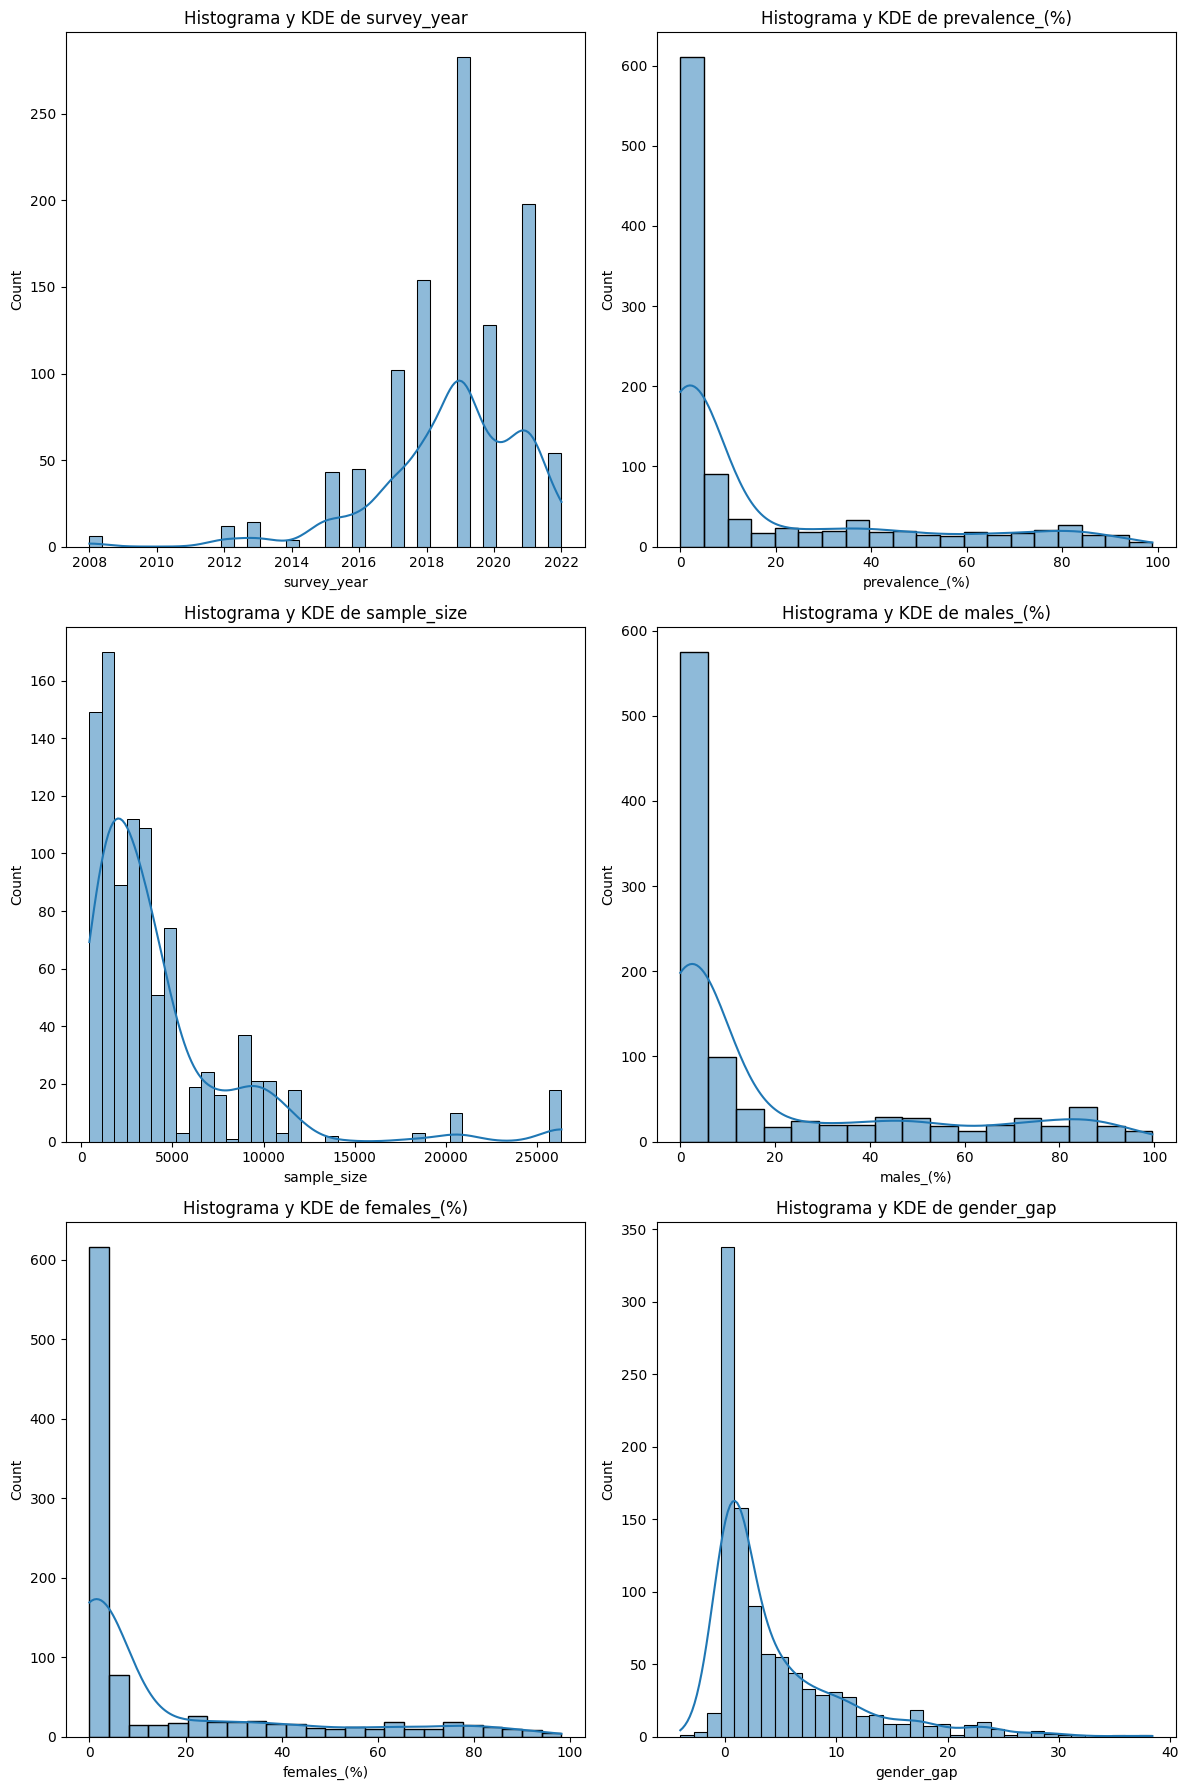

In [123]:
plot_histo_dens(df_drugs, columns=num_cols)

Estos histogramas muestran la distribución de cada una de las variables numéricas y nos permite identificar concentraciones de valores bajos, así como colas largas con registros extremos.

En las variables relevantes para la presente hipótesis, esto es, prevalence_(%), males_(%), females_(%), los valores se concentran, principalmente, en niveles bajos. No obstante, se aprecia la existencia de regsitros extremos que elevarían tanto la media como el rango.

Esta representación gráfica refuerza la interpretación de los boxplots y histogramas anteriores, mostrando de manera visual la heterogeneidad y dispersión de los datos.

En conclusión estos análisis confirman que las variables de consumo presentan gran variabilidad y outliers. 

Asimismo, los hombres tienen consumos más elevados en promedio que las mujeres, a pesar de que la dispersión es elevada, hecho que justificaría continuar con análisis bivariantes para explorar diferencias por sexo y grupos de edad.

## 1.2 ANÁLISIS BIVARIANTE

En primer lugar, se ha calculado la proporción de cada tipo de sustancia consumida dentro de cada grupo de edad, mostrando la frecuencia relativa  para comparar la distribución del consumo entre adultos y jóvenes

En segundo lugar, se han calculado estadísticas descriptivas de la prevalencia de consumo de los hombres en función de cada tipología de sustancia.

Asimismo, se han analizado estadísticas descriptivas de la prevalencia de consumo de las mujeres en función de cada tipología de sustancia.

También se ha estudiado para el consumo según la edad y en función de cada tipo de estupefaciente:

Ha sido interesante estudiar las estadísticas descriptivas de la prevalencia total del consumo para cada tipo de sustancia:

Asimismo, también se ha analizado la prevalencia del consumo en función al grupo de edad (jóven o adulto):

In [ ]:
plot_categorical_relationship_fin(df_drugs,"males_(%)""substance",relative_freq=True)

plot_categorical_relationship_fin(df_drugs,"females_(%)","substance",relative_freq=True)

### ANÁLISIS CATEGÓRICA - CATEGÓRICA

In [ ]:
df_drugs.groupby("age", as_index = False)["substance"].value_counts(normalize = True)

In [ ]:
df_drugs.groupby("substance")["age"].describe()

In [ ]:
plot_categorical_relationship_fin(df_drugs, "age", "substance", relative_freq=True, show_values=True)

In [ ]:
tabla_contingencia = pd.crosstab(df_drugs['substance'], df_drugs['age'])
tabla_contingencia

In [ ]:
chi2, p, dof, expected = chi2_contingency(tabla_contingencia)


print("Valor Chi-Cuadrado:", chi2)
print("P-Value:", p)
print("Grados de Libertad:", dof)
print("Tabla de Frecuencias Esperadas:\n", expected)


### ANÁLISIS NUMÉRICA - NUMÉRICA

In [ ]:
plot_combined_graphs(df_drugs,["prevalence_(%)"])

In [ ]:
plot_combined_graphs(df_drugs, ["males_(%)"])

In [ ]:
plot_combined_graphs(df_drugs, ["females_(%)"])

In [ ]:
df_drugs[["prevalence_(%)","females_(%)"]].corr()

In [ ]:
grafico_dispersion_con_correlacion(df_drugs, "prevalence_(%)", "females_(%)", mostrar_correlacion=True)

In [ ]:
df_drugs[["prevalence_(%)","males_(%)"]].corr()

In [ ]:
grafico_dispersion_con_correlacion(df_drugs, "prevalence_(%)", "males_(%)", mostrar_correlacion=True)

### ANÁLISIS CATEGÓRICA - NUMÉRICA

In [ ]:
df_drugs.groupby("substance")["males_(%)"].describe()

In [ ]:
plot_categorical_relationship_fin(df_drugs, "males_(%)", "substance", relative_freq=True)

In [ ]:
df_drugs.groupby("substance")["females_(%)"].describe()

In [ ]:
plot_categorical_relationship_fin(df_drugs, "females_(%)", "substance", relative_freq=True)

In [ ]:
df_drugs.groupby("substance")["prevalence_(%)"].describe()

In [ ]:
pinta_distribucion_categoricas(df_drugs,["substance"], relativa= True, mostrar_valores= True)

In [ ]:
df_drugs.groupby("age")["prevalence_(%)"].describe()

In [ ]:
pinta_distribucion_categoricas(df_drugs,["age"], relativa= True, mostrar_valores= True)

In [ ]:
# EDAD - CONSUMO
grupos = df_drugs['age'].unique()  # ["Adults (15-64)", "Young adults (15-34)"]

# Crear la lista de valores de prevalencia por grupo
prevalencia_por_grupo = [df_drugs[df_drugs['age'] == grupo]['prevalence_(%)'].dropna() for grupo in grupos]

# ANOVA
f_val, p_val = stats.f_oneway(*prevalencia_por_grupo)

print("Valor F:", f_val)
print("Valor p:", p_val)

In [ ]:
# EDAD - MALES
grupos = df_drugs['age'].unique()  # ["Adults (15-64)", "Young adults (15-34)"]

# Crear la lista de valores de prevalencia por grupo
prevalencia_por_grupo = [df_drugs[df_drugs['age'] == grupo]['males_(%)'].dropna() for grupo in grupos]

# ANOVA
f_val, p_val = stats.f_oneway(*prevalencia_por_grupo)

print("Valor F:", f_val)
print("Valor p:", p_val)

In [ ]:
# edad - FEMALES
grupos = df_drugs['age'].unique() 

# Crear la lista de valores de prevalencia por grupo
prevalencia_por_grupo = [df_drugs[df_drugs['age'] == grupo]['females_(%)'].dropna() for grupo in grupos]

# ANOVA
f_val, p_val = stats.f_oneway(*prevalencia_por_grupo)

print("Valor F:", f_val)
print("Valor p:", p_val)

In [ ]:
#SUSTANCIA - MALES
grupos = df_drugs['substance'].unique()  # ["Adults (15-64)", "Young adults (15-34)"]

# Crear la lista de valores de prevalencia por grupo
prevalencia_por_grupo = [df_drugs[df_drugs['substance'] == grupo]['males_(%)'].dropna() for grupo in grupos]

# ANOVA
f_val, p_val = stats.f_oneway(*prevalencia_por_grupo)

print("Valor F:", f_val)
print("Valor p:", p_val)

In [ ]:
#SUSTANCIA - FEMALES
grupos = df_drugs['substance'].unique()  # ["Adults (15-64)", "Young adults (15-34)"]

# Crear la lista de valores de prevalencia por grupo
prevalencia_por_grupo = [df_drugs[df_drugs['substance'] == grupo]['females_(%)'].dropna() for grupo in grupos]

# ANOVA
f_val, p_val = stats.f_oneway(*prevalencia_por_grupo)

print("Valor F:", f_val)
print("Valor p:", p_val)

In [ ]:
#SUSTANCIA - PREVALENCIA
grupos = df_drugs['substance'].unique()  # ["Adults (15-64)", "Young adults (15-34)"]

# Crear la lista de valores de prevalencia por grupo
prevalencia_por_grupo = [df_drugs[df_drugs['substance'] == grupo]['prevalence_(%)'].dropna() for grupo in grupos]

# ANOVA
f_val, p_val = stats.f_oneway(*prevalencia_por_grupo)

print("Valor F:", f_val)
print("Valor p:", p_val)

In [ ]:
#diferencia de consumo por edad en funcion de prevalencia y tipo de droga
df_age = df_drugs[df_drugs["recall_period"] == "Last year"]

df_age = (
    df_age.sort_values("survey_year")
    .groupby(["substance", "age"])
    .tail(1)
)

grupos_edad = [
    df_age[df_age["age"] == edad]["prevalence_(%)"]
    for edad in df_age["age"].unique()
]

f_val, p_val = stats.f_oneway(*grupos_edad)

print("ANOVA por edad")
print("F:", f_val)
print("p:", p_val)

In [ ]:
#anova por sustancia
grupos_sustancia = [
    df_age[df_age["substance"] == sust]["prevalence_(%)"]
    for sust in df_age["substance"].unique()
]

f_val, p_val = stats.f_oneway(*grupos_sustancia)

print("ANOVA por sustancia")
print("F:", f_val)
print("p:", p_val)

In [ ]:
sns.barplot(
    data=df_age,
    x="substance",
    y="prevalence_(%)",
    hue="age",
    ci="sd"
)

plt.title("Consumo de drogas por edad (Last year)")
plt.ylabel("Prevalencia (%)")
plt.xlabel("Sustancia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

 . 

Igual que con el análisis anterior, el bivariante lo vamos a dividir entre las variables categóricas y numéricas

## 1.3 ANÁLISIS MULTIVARIANTE

Para comparar la prevalencia de consumo entre sustancias según la proporción de mujeres, hombres y de la edad

In [ ]:
pivot1 = df_drugs.pivot_table(
    values="prevalence_(%)",
    index="females_(%)",
    columns="substance"
)

In [ ]:
pivot2 = df_drugs.pivot_table(
    values="prevalence_(%)",
    index="males_(%)",
    columns="substance"
)

In [ ]:
pivot3 = df_drugs.pivot_table(
    values="prevalence_(%)",
    index="age",
    columns="substance"
)

Vamos a ver datos descriptivos para resumir  cómo se distribuyen las variables numéricas por grupo de edad:

In [ ]:
cols_num = ["prevalence_(%)", "males_(%)", "females_(%)"]

df_summary = (
    df_drugs_no_na
    .groupby("age")[cols_num]
    .agg(["mean", "median", "std"])
)

df_summary

Para facilitar analisis  posteriores, hacemos analisis descriptivo

In [ ]:
df_drugs_num = df_drugs.select_dtypes(include = ["float","int"])
df_drugs_num.columns

Tabla cruzada para hacer el análisis y comparar simultáneamente:
* Edad (age)
* Tipo de sustancia (substance)
* Género (gender)
* Prevalencia del consumo (prevalence)

In [ ]:
df_gender2 = df_drugs.melt(
    id_vars=["substance", "age"],
    value_vars=["males_(%)", "females_(%)", "prevalence_(%)"],
    var_name="gender",
    value_name="prevalence"
)

df_gender2["gender"] = df_gender2["gender"].str.replace("_(%)", "", regex=False)
df_gender2["prevalence"] = pd.to_numeric(df_gender2["prevalence"], errors="coerce")

df_gender2.head()

pivot_gender2 = df_gender2.pivot_table(
    values="prevalence",
    index="age",
    columns=["substance", "gender"],
    aggfunc="mean"
)

pivot_gender2.head()

Vamos a identificar:
* En qué drogas la diferencia entre hombres y mujeres es mayor
* Qué grupo de edad tiene esa mayor brecha

In [ ]:
topN = 10
rank_gap = (
    df_drugs.dropna(subset=["gender_gap"])
    .sort_values("gender_gap", ascending=False)
    .groupby("substance")
    .head(topN)
)

rank_gap[["substance", "age", "gender_gap"]]

**Comparacion por edad**

In [ ]:
#4 Comparación por edad( Young adults vs Adults)
# 1. Filtrar solo consumo en el último año
df_age = df_drugs[df_drugs["recall_period"] == "Last year"]

# 2. Quedarse con el dato más reciente por sustancia y edad
df_age = (
    df_age.sort_values("survey_year")
    .groupby(["substance", "age"])
    .tail(1)
)

# 3. Tabla de comparación por edad
pivot_age = df_age.pivot_table(
    values="prevalence_(%)",
    index="substance",
    columns="age",
    aggfunc="mean"
)

# 4. Diferencia entre jóvenes y adultos
pivot_age["young_minus_adults"] = (
    pivot_age["Young adults (15-34)"] - pivot_age["Adults (15-64)"]
)

print(pivot_age)

In [ ]:
# 5. Visualización
pivot_age[["Adults (15-64)", "Young adults (15-34)"]].plot(
    kind="bar",
    figsize=(10, 6)
)

plt.ylabel("Prevalencia (%)")
plt.title("Consumo de drogas por grupo de edad (Last year)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**genero**

Identificar relaciones lineales entre variables numéricas,
calcular la matriz de correlación entre todas las variables numéricas del dataframe

In [ ]:
corr_matrix = df_drugs.corr(numeric_only= True)
corr_matrix

In [ ]:
plt.figure(figsize=(10, 8)) 
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm",
           cbar=True, square=True, linewidths=.5) 


plt.title('Matriz de Correlación')
plt.xticks(rotation=45)
plt.yticks(rotation=45) 


plt.show()


**Genero, edad y sustancia**

In [ ]:
#prevalencia consuno en hombres y mujeres en funcion de droga y la edad
df_mv = df_drugs[df_drugs["recall_period"]=="Last year"].copy()
# Variables dependientes
y_vars = ['males_(%)','females_(%)']

# Fórmula: dependientes ~ factores
formula = 'Q("males_(%)") + Q("females_(%)") ~ C(age) + C(substance) + C(age):C(substance)'

manova = MANOVA.from_formula(formula, data=df_mv)
result = manova.mv_test()
print(result)

**Genero, edad y prevalencia**

In [ ]:
df_mv = df_drugs[df_drugs["recall_period"]=="Last year"].copy()
# Variables dependientes
y_vars = ['males_(%)','females_(%)']

# Fórmula: dependientes ~ factores
formula = 'Q("males_(%)") + Q("females_(%)") ~ C(age) + C(substance) + C(age):C(substance)'

manova = MANOVA.from_formula(formula, data=df_mv)
result = manova.mv_test()
print(result)

In [ ]:
# Variables dependientes
y_vars = ["prevalence"]

# MANOVA: dependiente ~ edad + género + interacción
# Si solo hay 1 variable dependiente, MANOVA se reduce a ANOVA, pero estructura es la misma
formula = 'prevalence ~ C(age) + C(gender) + C(age):C(gender)'

manova = MANOVA.from_formula(formula, data=df_mv_long)
result = manova.mv_test()
print(result)

In [ ]:
# Pivot para heatmap
pivot_heat = df_mv_long.pivot_table(
    values="prevalence",
    index="age",
    columns="gender",
    aggfunc="mean"
)

plt.figure(figsize=(8,5))
sns.heatmap(pivot_heat, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Prevalencia de consumo por edad y género")
plt.show()

análisis multivariante para estudiar si existen diferencias en el consumo de drogas entre hombres y mujeres según la edad y el tipo de sustancia.

MANOVA: evalúa simultáneamente si la prevalencia en hombres (males_(%)) y mujeres (females_(%)) varía según la edad, la sustancia y su interacción.

Brecha de género: calcula la diferencia entre hombres y mujeres (gender_gap) y comprueba estadísticamente si difiere por edad o sustancia mediante ANOVA.

Post-hoc: compara directamente hombres y mujeres dentro de cada combinación de edad y sustancia para identificar en qué grupos la diferencia es más marcada.

Visualización: un gráfico de barras muestra la brecha de género promedio por sustancia y grupo de edad, facilitando la interpretación de los resultados.

In [ ]:
from scipy.stats import f_oneway
# -----------------------------
# 1️⃣ Preparar los datos
# -----------------------------
df_mv = df_drugs[df_drugs["recall_period"]=="Last year"].copy()

# Filtrar filas con valores NaN en males o females
df_mv = df_mv.dropna(subset=["males_(%)","females_(%)"])

# -----------------------------
# 2️⃣ MANOVA
# -----------------------------
# Variables dependientes: males y females
# Factores: age y substance + interacción
formula = 'Q("males_(%)") + Q("females_(%)") ~ C(age) + C(substance) + C(age):C(substance)'

manova = MANOVA.from_formula(formula, data=df_mv)
print("===== RESULTADOS MANOVA =====")
print(manova.mv_test())

# -----------------------------
# 3️⃣ Brecha de género
# -----------------------------
df_mv["gender_gap"] = df_mv["males_(%)"] - df_mv["females_(%)"]

# ANOVA de la brecha según edad y sustancia
# ANOVA por edad
grupos_edad = [df_mv[df_mv["age"]==edad]["gender_gap"] for edad in df_mv["age"].unique()]
f_val, p_val = f_oneway(*grupos_edad)
print("\nANOVA de brecha por edad")
print("F:", f_val)
print("p:", p_val)

# ANOVA por sustancia
grupos_sustancia = [df_mv[df_mv["substance"]==s]["gender_gap"] for s in df_mv["substance"].unique()]
f_val2, p_val2 = f_oneway(*grupos_sustancia)
print("\nANOVA de brecha por sustancia")
print("F:", f_val2)
print("p:", p_val2)

# -----------------------------
# 4️⃣ Post-hoc: diferencias específicas
# -----------------------------
# Comparar brecha dentro de cada sustancia y edad
print("\nPost-hoc: brecha por sustancia y edad")
for sust, age in itertools.product(df_mv["substance"].unique(), df_mv["age"].unique()):
    grupo = df_mv[(df_mv["substance"]==sust) & (df_mv["age"]==age)]
    if grupo.shape[0] > 1:  # necesitamos al menos 2 observaciones
        f_post, p_post = f_oneway(grupo["males_(%)"], grupo["females_(%)"])
        print(f"Sustancia: {sust}, Edad: {age}, F: {f_post:.2f}, p: {p_post:.4f}")


In [ ]:
# -----------------------------
# 5️⃣ Visualización 
# -----------------------------
plt.figure(figsize=(12,6))
sns.barplot(data=df_mv, x="substance", y="gender_gap", hue="age", ci="sd")
plt.title("Brecha de género (hombres - mujeres) por sustancia y edad")
plt.ylabel("Brecha de género (%)")
plt.xlabel("Sustancia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**gráficas**

In [ ]:
#2.heatmap2: Brecha de género( hombres-mujeres)

pivot_gap2 = df_drugs.pivot_table(
    values="gender_gap",
    index="age",
    columns="substance",
    aggfunc="mean"
)

plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_gap2,
    cmap="BrBG",
    center=0,
    annot=True,
    fmt=".1f"
)
plt.title("Brecha de género media por edad y sustancia")
plt.xlabel("Sustancia")
plt.ylabel("Grupo de edad")
plt.tight_layout()
plt.show()

In [ ]:
#Esto es otro heatmap para ver exactamente para los hombres y para las mujeres
plt.figure(figsize=(14,8))
sns.heatmap(pivot_gender2, cmap="YlOrRd", annot=True)
plt.title("Prevalencia por edad, sustancia y género")
plt.ylabel("Edad")
plt.xlabel("Sustancia y género")
plt.show()

## CONCLUSIÓN

# **HIPÓTESIS 2**

*H2. Existen diferencias en la prevalencia del consumo de estupefacientes entre países europeos*

Igual que anteriormente, mostramos el dataframe:

In [45]:
df_drugs

,country,survey_year,prevalence_(%),substance,recall_period,age,sample_size,males_(%),females_(%),gender_gap
0,Austria,2020,22.7,Cannabis,Lifetime,Adults (15-64),4650.0,24.8,20.6,4.2
1,Austria,2020,27.2,Cannabis,Lifetime,Young adults (15-34),1712.0,26.8,27.6,-0.8
2,Austria,2020,6.3,Cannabis,Last year,Adults (15-64),4650.0,6.8,5.8,1.0
3,Austria,2020,11.1,Cannabis,Last year,Young adults (15-34),1712.0,10.7,11.4,-0.7
4,Austria,2020,3.6,Cannabis,Last month,Adults (15-64),4650.0,4.0,3.1,0.9
...,...,...,...,...,...,...,...,...,...,...
1038,Türkiye,2017,47.0,Tobacco,Lifetime,Young adults (15-34),NaN,61.9,33.2,28.7
1039,Türkiye,2017,33.4,Tobacco,Last year,Adults (15-64),NaN,45.0,22.5,22.5
1040,Türkiye,2017,33.2,Tobacco,Last year,Young adults (15-34),NaN,45.4,20.6,24.8
1041,Türkiye,2017,31.5,Tobacco,Last month,Adults (15-64),NaN,42.8,21.0,21.8


## 2.1 ANÁLISIS UNIVARIANTE

Las principales variables analizadas en esta hipótesis serán: country

Por ello, vamos a mostrar ciertos datos descriptivos para tener más información de las variables

In [46]:
df_drugs["country"].describe()

count        1043
unique         29
top       Austria
freq           42
Name: country, dtype: object

In [47]:
df_drugs["recall_period"].describe()

count          1043
unique            3
top       Last year
freq            367
Name: recall_period, dtype: object

### Variables **Categóricas**

In [48]:
df_drugs.columns = df_drugs.columns.str.lower()

In [49]:
categorical_cols = [
    "country",    
    "substance",
    "recall_period",
    "age"
]

Hacemos el conteo de los valores:

In [50]:
from IPython.display import display
for col in categorical_cols:
    print(f"\n--- {col}---")
    display(df_drugs[col].value_counts(dropna=False))


--- country---


country
Austria        42
Bulgaria       42
Croatia        42
Cyprus         42
Germany        42
Portugal       42
Romania        42
Italy          42
Slovakia       42
Ireland        42
Latvia         41
Czechia        40
Lithuania      40
Hungary        38
Finland        38
Türkiye        38
Poland         36
Estonia        36
Spain          36
Luxembourg     36
Netherlands    34
Slovenia       34
Greece         32
Denmark        30
France         30
Norway         30
Sweden         22
Belgium        20
Malta          12
Name: count, dtype: int64


--- substance---


substance
Cannabis        171
Cocaine         159
Ecstasy         159
Amphetamines    149
LSD             148
Alcohol         132
Tobacco         125
Name: count, dtype: int64


--- recall_period---


recall_period
Last year     367
Lifetime      348
Last month    328
Name: count, dtype: int64


--- age---


age
Adults (15-64)          528
Young adults (15-34)    515
Name: count, dtype: int64

En esta tabla podemos ver el número y nombre de los países, las sustancias que se incluyen (como el alcohol), los períodos y los grupos de edad

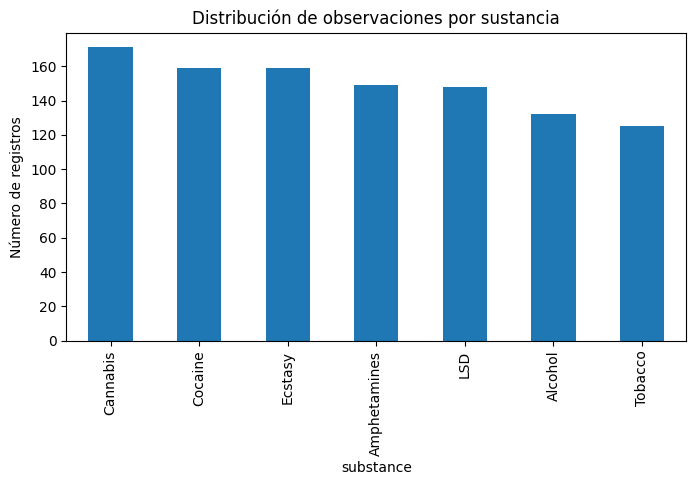

In [53]:
#Gráficos sustancias
plt.figure(figsize=(8,4))

df_drugs["substance"].value_counts().plot(kind="bar")

plt.title("Distribución de observaciones por sustancia")

plt.ylabel("Número de registros")

plt.show()

## 2.2 ANÁLISIS BIVARIANTE

### CATEGÓRICA - CATEGÓRICA

In [ ]:
df_drugs.groupby("substance")["country"].value_counts(normalize=True)

In [ ]:
plot_categorical_relationship_fin(df_drugs, "country", "substance", relative_freq=True, show_values=False, size_group=5)

In [ ]:
plot_categorical_relationship_fin(df_drugs, "country", "substance", relative_freq=False, show_values=True)

### CATEGORICA - NUMÉRICA

**Mirar para analizar la prevalencia de consumo por edad en los paises (o esto seria multivariante?)**

### Mio (Rebeca) adaptado al análisis

In [ ]:
df_drugs.groupby("country")["females_(%)"].describe()

In [ ]:
plot_categorical_relationship_fin(df_drugs, "females_(%)", "country", relative_freq=True)

In [ ]:
df_drugs.groupby("country")["males_(%)"].describe()

In [ ]:
plot_categorical_relationship_fin(df_drugs, "males_(%)", "country", relative_freq=True)

In [ ]:
df_drugs.groupby("country")["prevalence_(%)"].describe()

In [ ]:
plot_categorical_relationship_fin(df_drugs, "prevalence_(%)", "country", relative_freq=True)

In [ ]:
#  COUNTRY - CONSUMO
grupos2 = df_drugs['country'].dropna().unique()

# Crear la lista de valores de prevalencia por grupo
prevalencia_por_grupo2 = [df_drugs[df_drugs['age'] == grupo]['prevalence_(%)'].dropna() for grupo in grupos]

prevalencia_por_grupo2 = [df_drugs[df_drugs['country'] == grupo]['prevalence_(%)'].dropna()
    for grupo in grupos
    if df_drugs[df_drugs['country'] == grupo]['prevalence_(%)'].dropna().shape[0] > 1
]


# ANOVA
f_val, p_val = stats.f_oneway(*prevalencia_por_grupo2)

print("Valor F:", f_val)
print("Valor p:", p_val)

In [ ]:
#diferencia de consumo por country en funcion de prevalencia y tipo de droga 
df_country = df_drugs[df_drugs["recall_period"] == "Last year"]

df_country = (
    df_country.sort_values("survey_year")
    .groupby(["substance", "country"])
    .tail(1)
)

grupos_country = [
    df_country[df_country["country"] == country]["prevalence_(%)"].dropna()
    for country in df_country["country"].unique()
    if df_country[df_country["country"] == country]["prevalence_(%)"].dropna().shape[0] > 1
]

f_val, p_val = stats.f_oneway(*grupos_country)

print("ANOVA por país")
print("F:", f_val)
print("p:", p_val)

In [ ]:
#anova por sustancia
grupos_country = [
    df_age[df_age["country"] == country]["prevalence_(%)"].dropna()
    for country in df_age["country"].unique()
    if df_age[df_age["country"] == country]["prevalence_(%)"].dropna().shape[0] > 1
]

f_val, p_val = stats.f_oneway(*grupos_country)

print("ANOVA por país")
print("F:", f_val)
print("p:", p_val)

In [ ]:
sns.barplot(
    data=df_age,
    x="substance",
    y="prevalence_(%)",
    hue="age",
    ci="sd"
)

plt.title("Consumo de drogas por edad (Last year)")
plt.ylabel("Prevalencia (%)")
plt.xlabel("Sustancia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2.3 ANÁLISIS MULTIVARIANTE

In [ ]:
#Cruzamos país+ sustancia+género 

pivot = df_drugs.pivot_table(
    values="prevalence_(%)",
    index="country",
    columns="substance"
)


In [ ]:
# 1) Crear pivot
pivot = df_drugs.pivot_table(
    values="prevalence_(%)",
    index="country",
    columns="substance",
    aggfunc="mean"
)

# 2) Pintar heatmap
plt.figure(figsize=(12,8))
sns.heatmap(pivot)
plt.title("Mapa de calor de prevalencia por país y sustancia")
plt.show()

In [ ]:
df_gender = df_drugs.melt(
    id_vars=["country", "substance", "survey_year", "recall_period", "age"],
    value_vars=["males_(%)", "females_(%)"],
    var_name="gender",
    value_name="prevalence"
)

df_gender["gender"] = df_gender["gender"].str.replace("_(%)", "", regex=False)
df_gender["prevalence"] = pd.to_numeric(df_gender["prevalence"], errors="coerce")

df_gender.head()

pivot_gender = df_gender.pivot_table(
    values="prevalence",
    index="country",
    columns=["substance", "gender"],
    aggfunc="mean"
)

pivot_gender.head()

In [ ]:
#2.heatmap2: Brecha de género( hombres-mujeres)

pivot_gap = df_drugs.pivot_table(
    values="gender_gap",
    index="country",
    columns="substance",
    aggfunc="mean"
)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_gap, cmap= "BrBG",
            center=0,)
plt.title("Mapa de calor: brecha de género (Hombres − Mujeres)")
plt.xlabel("Sustancia")
plt.ylabel("País")
plt.tight_layout()
plt.show()

In [ ]:
#3 Países con mayor brecha de género
topN = 10
rank_gap = (
    df_drugs.dropna(subset=["gender_gap"])
    .sort_values("gender_gap", ascending=False)
    .groupby("substance")
    .head(topN)
)

rank_gap[["substance", "country", "survey_year", "gender_gap"]]

In [ ]:
#4 Comparación por edad( Young adults vs Adults)
df_age = df_drugs[df_drugs["recall_period"] == "Last year"]

df_age = (
    df_age.sort_values("survey_year")
    .groupby(["country", "substance", "age"])
    .tail(1)
)

pivot_age = df_age.pivot_table(
    values="prevalence_(%)",
    index="country",
    columns=["age", "substance"],
    aggfunc="mean"
)

## CONCLUSIÓN

# ANOTACIONES

He añadido algunos análisis en el apartado de análisis univariante de la Hipótesis 2 para complementar las gráficas

## COSAS ELIMINADAS DE LA HIPOTESIS 2

### ANALISIS BIVARIANTE

**CATEGÓRICA - CATEGÓRICA**

Elimino las gráficas porque no nos interesa estudiar la relacion de recall period, el de substance-age tampoco porque lo he estudiado en la hipotesis 1. Y country - age tampoco nos aporte  información porque estamos estudiando el consumo por pais, no por año

In [ ]:
plot_categorical_relationship_fin(df_drugs, "country", "recall_period") #eliminar
plot_categorical_relationship_fin(df_drugs, "country", "age") #eliminar
plot_categorical_relationship_fin(df_drugs, "substance", "age", relative_freq=True) #eliminar

**NUMERICA - NUMERICA**

Elimino las gráficas que había porque no tenemos variables numericas para esta hipotesis

In [ ]:
grafico_dispersion_con_correlacion(df_drugs, "prevalence_(%)", "survey_year", mostrar_correlacion=True) #eliminarla
grafico_dispersion_con_correlacion(df_drugs, "prevalence_(%)", "sample_size", mostrar_correlacion=True) #eliminarla
grafico_dispersion_con_correlacion(df_drugs, "prevalence_(%)", "gender_gap", mostrar_correlacion=True) #eliminarla

No nos interesa hacer ninguna correlacion ni grafico entre el año de la encuesta, la grandaria de la muesttra ni gender_gap. Esto no tiene ninguna relacion con nuestra hipotesis de los paises

**CATEGORICA - NUMERICA**

En esta hipotesis no miramos las diferencias por genero, miramos por pais:

In [ ]:
#2.2 Diferencias por género  --> REVISAR PORQUE YO LO ELIMINARIA, NO TIENE SENTIDO EN ESTA HIPOTESIS
#Creamos una variable útil

df_std["gender_gap"] = df_std["males_(%)"] - df_std["females_(%)"]

In [ ]:
#VISUALIZACIÓN

plt.figure(figsize=(6,4))
sns.histplot(df_std["gender_gap"], kde=True)
plt.title("Distribución de la brecha de género (Hombres - Mujeres)")
plt.show()

En esta hipotesis no miramos el consumo por edad, no se esta comparando nada de edad por pais

In [ ]:
#Valores positivos consumen más los hombres ---> REVISAR PORQUE YO LO ELIMINARIA, NO TIENE SENTIDO EN ESTA HIPOTESIS
#Valores negativos más mujeres poco frecuente.
#2.3 Edad
df_age = df_drugs[df_drugs["recall_period"] == "Last year"].copy()

print(df_age.shape)  # para verificar que ya tiene filas

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.boxplot(data=df_age, x="age", y="prevalence_(%)")
plt.title("Prevalencia (%) por edad (Last year)")
plt.show()

Lo mismo con esta, no está mirando la prevalencia por pais, esta mirando solo la edad y el recall_period

In [94]:
#2.1 Prevalencia por país --> REVISAR PORQUE YO LO ELIMINARIA, HABLA DE EDAD! - PUEDO ADAPTARLO A COUNTRY
#Escenario estándar

df_std = df_drugs[
    (df_drugs["age"] == "Adults (15-64)") &
    (df_drugs["recall_period"] == "Last year")
]
#Todos los países por prevalencia (ej. cannabis)

df_std = df_drugs[
    (df_drugs["age"] == "Adults (15-64)") &
    (df_drugs["recall_period"] == "Last year")
]
